In [8]:
# importing libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import re
from scipy import stats
import numpy as np 
import pandas as pd
from keras import layers, regularizers

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, MaxPooling1D,  Input, Bidirectional, Conv1D, concatenate, Permute
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet

from tensorflow.keras.layers import Concatenate, Add, GlobalMaxPooling1D, Attention,Activation
from keras import regularizers
from keras import layers, regularizers

from scipy import stats
import numpy as np
import pandas as pd
from sklearn import metrics

from scipy import stats
import numpy as np
import pandas as pd
from sklearn import metrics

from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D, LSTM, Bidirectional, Permute, Concatenate, Attention, Input, Dense, Dropout, Multiply, Reshape
from tensorflow.keras import regularizers, Model
from tensorflow.keras.layers import Concatenate, Add, GlobalMaxPooling1D, Attention,Activation
from keras import regularizers
from keras import layers, regularizers
from sklearn.model_selection import train_test_split

In [9]:
#Globals
batch_size = 8
num_classes = 3  # classes, seizure/no seizure
epochs = 25      # Epoch iterations
row_hidden = 128  # hidden neurons in conv layers
col_hidden = 128   # hidden neurons in the Bi-LSTM layers
RANDOM_SEED = 333    
N_TIME_STEPS = 125   # 50 records in each sequence
N_FEATURES = 2      # mag,hr,roi_Ratio,output
step = 100           # window overlap = 50 -10 = 40  (80% overlap)
N_CLASSES = 3       # class labels

In [43]:
# reading data from google drive /content/gdrive/MyDrive/OSD Research/data/seizures.csv
mypath = '../Data/Train.csv'
df = pd.read_csv(mypath)
df.head()

,eventID,hr,rawData,label
0,5635,75,426.0,1
1,5635,75,2267.0,1
2,5635,75,2002.0,1
3,5635,75,4090.0,1
4,5635,75,3057.0,1


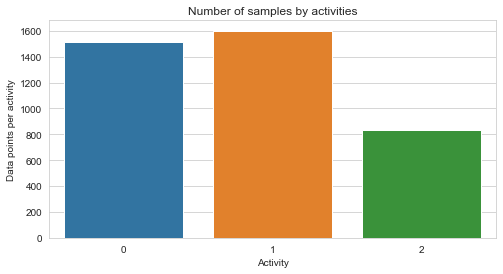

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Number of data points in class 1 = 1601.0 ~ 40.54%
Number of data points in class 0 = 1511.0 ~ 38.26%
Number of data points in class 2 = 837.0 ~ 21.2%
--------------------------------------------------
total datapoints: 3949.0


In [44]:
# analysis of class labels

label_dict = dict(df['label'].value_counts()/125)

sns.set_style("whitegrid")
plt.figure(figsize = (8, 4))
sns.barplot(x = list(label_dict.keys()), y = list(label_dict.values()))
plt.xlabel('Activity')
plt.ylabel('Data points per activity')
plt.title('Number of samples by activities')
plt.show()

# Percentage-wise distribution of the class label yi's
print("- "* 50)
for i in label_dict.keys():
  print("Number of data points in class {0} = {1} ~ {2}%".format(
  i, label_dict[i], round((label_dict[i]*100)/sum(label_dict.values()), 2)))



print("-"*50)
print("total datapoints:", sum(label_dict.values()))

In [45]:


RANDOM_SEED = 333    
N_TIME_STEPS = 125   # 50 records in each sequence
N_FEATURES = 2      # mag,hr,roi_Ratio,output
step = 100           # window overlap = 50 -10 = 40  (80% overlap)
N_CLASSES = 3       # class labels

segments = []
labels = []

for i in range(0, df.shape[0] - N_TIME_STEPS, step):  
    mag = df['rawData'].values[i: i + N_TIME_STEPS]
    hr = df['hr'].values[i: i + N_TIME_STEPS]
    segement = np.column_stack((mag, hr))  # Stack acceleration and heart rate features horizontally
    label = stats.mode(df['label'][i: i + N_TIME_STEPS])[0][0]
    segments.append(segement)
    labels.append(label)

# Convert segments and labels to numpy arrays
segments = np.asarray(segments, dtype=np.float32)
labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.25, random_state=RANDOM_SEED)

print(X_test.shape, y_test.shape)


# Assuming X_train and X_test have shape (samples, timesteps, 1)
X_train = X_train.reshape(-1, N_TIME_STEPS, N_FEATURES)  # Reshape to include the feature dimension
X_test = X_test.reshape(-1, N_TIME_STEPS, N_FEATURES)    # Reshape to include the feature dimension


# Assuming X_train and X_test are already defined with shape (samples, timesteps, features)

# Assuming X_train_acceleration and X_train_heart_rate are defined with shape (samples, timesteps, 1)
X_train_acceleration = X_train[:, :, 0].reshape(-1, N_TIME_STEPS, 1)  # Reshape to include timestep dimension
X_train_heart_rate = X_train[:, :, 1].reshape(-1, N_TIME_STEPS, 1)    # Reshape to include timestep dimension

# Similarly for X_test data
X_test_acceleration = X_test[:, :, 0].reshape(-1, N_TIME_STEPS, 1)    # Reshape to include timestep dimension
X_test_heart_rate = X_test[:, :, 1].reshape(-1, N_TIME_STEPS, 1)      # Reshape to include timestep dimension

(1234, 125, 2) (1234, 3)


In [50]:
print("X_test_heart_rate",X_test_heart_rate.shape)
print("X_test_acceleration",X_test_acceleration.shape)
print("X_train_heart_rate",X_train_heart_rate.shape)
print("X_test",X_test.shape)
print("X_train",X_train.shape)

X_test_heart_rate (1234, 125, 1)
X_test_acceleration (1234, 125, 1)
X_train_heart_rate (3701, 125, 1)
X_test (1234, 125, 2)
X_train (3701, 125, 2)


In [51]:
print("X Test Shape = ", X_test.shape, "Y Test Shape =", y_test.shape)
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("X_train_heart_rate", X_train_heart_rate.shape)
print("X_train_acceleration", X_train_acceleration.shape)
print("X_train_heart_rate", X_train_heart_rate.shape)
print("X_test_acceleration", X_test_acceleration.shape)
print("X_test_heart_rate", X_test_heart_rate.shape)

X Test Shape =  (1234, 125, 2) Y Test Shape = (1234, 3)
X_train (3701, 125, 2)
X_test (1234, 125, 2)
X_train_heart_rate (3701, 125, 1)
X_train_acceleration (3701, 125, 1)
X_train_heart_rate (3701, 125, 1)
X_test_acceleration (1234, 125, 1)
X_test_heart_rate (1234, 125, 1)


In [15]:
# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=0.0001, verbose=1)

# Callbacks
callbacks = [
    ModelCheckpoint(
        "../Models/model.h5", save_best_only=True, monitor="val_loss"
    ),
    reduce_lr,  # Include ReduceLROnPlateau callback
]

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Permute

# Assuming X_train_acceleratio                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        n, X_train_heart_rate, X_test_acceleration, X_test_heart_rate are defined
# Assuming model is already defined

# Check the shape of input data
print("Shape of X_train_acceleration:", X_train_acceleration.shape)
print("Shape of X_train_heart_rate:", X_train_heart_rate.shape)
print("Shape of X_test_acceleration:", X_test_acceleration.shape)
print("Shape of X_test_heart_rate:", X_test_heart_rate.shape)

# Iterate over each layer in the model
for layer in model.layers:
    # Print the layer name and input shape
    print("Layer:", layer.name)
    print("Input shape expected by the layer:", layer.input_shape)

# Check the input shapes expected by permute_26 layer
permute_26_layer = None
for layer in model.layers:
    if layer.name == 'permute_26':
        permute_26_layer = layer
        break

if permute_26_layer is not None:
    print("Input shape expected by permute_26 layer:", permute_26_layer.input_shape)
else:
    print("permute_26 layer not found in the model.")


Shape of X_train_acceleration: (3701, 125, 1)
Shape of X_train_heart_rate: (3701, 125, 1)
Shape of X_test_acceleration: (1234, 125, 1)
Shape of X_test_heart_rate: (1234, 125, 1)


NameError: name 'model' is not defined

In [ ]:
#BUILD MODEL

# Define regularization strength
l2_regularizer_strength = 0.001

# Assuming X_train is your input data with shape (3701, 125, 1)
row, features = X_train_acceleration.shape[1:]

# Define input shapes for each modality
input_acceleration = Input(shape=(row, features), name='input_acceleration')
input_heart_rate = Input(shape=(row, features), name='input_heart_rate')

# Your code for CNN and LSTM branches


# LSTM branch for acceleration
trans_read_acceleration = lstm_pipe(Permute(dims=(1, 2))(input_acceleration), row_hidden, col_hidden)

# LSTM branch for heart rate
trans_read_heart_rate = lstm_pipe(Permute(dims=(1, 2))(input_heart_rate), row_hidden, col_hidden)


# Attention Mechanisms

# Attention Mechanism for acceleration
attention_acceleration = Attention()([trans_read_acceleration, trans_read_acceleration])

# Attention Mechanism for heart rate
attention_heart_rate = Attention()([trans_read_heart_rate, trans_read_heart_rate])

# Print the shapes of attention mechanisms using eager execution
print("Shape of attention_acceleration:", attention_acceleration.shape)
print("Shape of attention_heart_rate:", attention_heart_rate.shape)


# Modality-specific attention weights

# Reshape attention weights to match the shape of trans_read_acceleration and trans_read_heart_rate
reshaped_attention_weights_acceleration = Reshape((-1, 1))(attention_acceleration)
reshaped_attention_weights_heart_rate = Reshape((-1, 1))(attention_heart_rate)

# Apply attention weights to features
weighted_features_acceleration = Multiply()([trans_read_acceleration, reshaped_attention_weights_acceleration])
weighted_features_heart_rate = Multiply()([trans_read_heart_rate, reshaped_attention_weights_heart_rate])

# Concatenate attention-weighted features
concatenated_features = Concatenate()([weighted_features_acceleration, weighted_features_heart_rate])

# Your code for dense layers, prediction layer, and model compilation

# Define your layer with L2 regularization
layer = Dense(units=64, kernel_regularizer=regularizers.l2(0.01))

# Dense layers
dense_output = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_regularizer_strength))(concatenated_features)
dense_output = Dropout(0.6)(dense_output)
dense_output = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_regularizer_strength))(dense_output)

epsilon_value = 1e-9  # Example epsilon value, you can adjust this value

# Define the learning rate
learning_rate = 0.001  # Example learning rate, you can adjust this value

# Create an instance of the Adam optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate,epsilon=epsilon_value)

# Prediction layer
prediction = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(l2_regularizer_strength))(dense_output)

# Define model with modality-specific inputs
model = Model(inputs=[input_acceleration, input_heart_rate], outputs=prediction)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Shape of attention_acceleration: (None, 128)
Shape of attention_heart_rate: (None, 128)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_acceleration (InputLayer) [(None, 125, 1)]     0                                            
__________________________________________________________________________________________________
input_heart_rate (InputLayer)   [(None, 125, 1)]     0                                            
__________________________________________________________________________________________________
permute_13 (Permute)            (None, 125, 1)       0           input_acceleration[0][0]         
__________________________________________________________________________________________________
permute_14 (Permute)            (None, 125, 1)       0           input_heart_rate[0][0]           
____

In [ ]:
import tensorflow as tf

# Check if GPU is available and visible to TensorFlow
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPU is available")
    # Restrict TensorFlow to only allocate memory on demand
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU available")

# Check TensorFlow's GPU usage
print("TensorFlow GPU support: ", tf.test.gpu_device_name())


No GPU available
TensorFlow GPU support:  


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='../Results/model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
print("X_train_acceleration",X_train_acceleration.shape)
print("X_train_heart_rate", X_train_heart_rate.shape)
print("X_test_acceleration", X_test_acceleration.shape)
print("X_test_heart_rate", X_test_heart_rate.shape)
print("input_acceleration", input_acceleration.shape)
print("input_heart_rate", input_heart_rate.shape)
print("prediction", prediction.shape)
print("dense_output", dense_output.shape)

X_train_acceleration (3701, 125, 1)
X_train_heart_rate (3701, 125, 1)
X_test_acceleration (1234, 125, 1)
X_test_heart_rate (1234, 125, 1)
input_acceleration (None, 125, 1)
input_heart_rate (None, 125, 1)
prediction (None, 128, 3)
dense_output (None, 128, 128)


In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Reshape target data to match the sequence length of the model output
y_train_reshaped = np.repeat(y_train[:, np.newaxis, :], 128, axis=1)
y_test_reshaped = np.repeat(y_test[:, np.newaxis, :], 128, axis=1)

# Print the shapes to verify
print("Shape of y_train_reshaped:", y_train_reshaped.shape)
print("Shape of y_test_reshaped:", y_test_reshaped.shape)

from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Define the number of folds
k = 5  # You can adjust this number as needed

# Initialize k-fold cross-validation
kf = KFold(n_splits=k, shuffle=False)

# Initialize lists to store evaluation metrics
all_test_losses = []
all_test_accuracies = []

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(kf.split(X_train_acceleration)):
    print(f"Fold {fold + 1}/{k}")

    # Split data into train and test sets for this fold
    X_fold_train_acceleration, X_fold_test_acceleration = X_train_acceleration[train_index], X_train_acceleration[test_index]
    X_fold_train_heart_rate, X_fold_test_heart_rate = X_train_heart_rate[train_index], X_train_heart_rate[test_index]
    y_fold_train, y_fold_test = y_train_reshaped[train_index], y_train_reshaped[test_index]

    # Assuming you have already defined and compiled your model
    # Train the model
    history = model.fit(
        [X_fold_train_acceleration, X_fold_train_heart_rate],  # input data
        y_fold_train,  # target data
        batch_size=batch_size,
        epochs=epochs,
        validation_data=([X_fold_test_acceleration, X_fold_test_heart_rate], y_fold_test),
        callbacks=callbacks
    )

    # Evaluate the model on the test set for this fold
    test_loss, test_accuracy = model.evaluate([X_fold_test_acceleration, X_fold_test_heart_rate], y_fold_test)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store evaluation metrics for this fold
    all_test_losses.append(test_loss)
    all_test_accuracies.append(test_accuracy)

# Calculate and print average performance across all folds
avg_test_loss = np.mean(all_test_losses)
avg_test_accuracy = np.mean(all_test_accuracies)
print("Average Test Loss:", avg_test_loss)
print("Average Test Accuracy:", avg_test_accuracy)

Shape of y_train_reshaped: (3701, 128, 3)
Shape of y_test_reshaped: (1234, 128, 3)
Fold 1/5
Epoch 1/25
370/370 [==============================] - 42s 84ms/step - loss: 0.9762 - accuracy: 0.6864 - val_loss: 0.5700 - val_accuracy: 0.8206
Epoch 2/25
370/370 [==============================] - 25s 69ms/step - loss: 0.6641 - accuracy: 0.7741 - val_loss: 0.5282 - val_accuracy: 0.8262
Epoch 3/25
370/370 [==============================] - 25s 68ms/step - loss: 0.5799 - accuracy: 0.8063 - val_loss: 0.4161 - val_accuracy: 0.8702
Epoch 4/25
370/370 [==============================] - 25s 69ms/step - loss: 0.5382 - accuracy: 0.8048 - val_loss: 0.5463 - val_accuracy: 0.8150
Epoch 5/25
370/370 [==============================] - 25s 68ms/step - loss: 0.5160 - accuracy: 0.7985 - val_loss: 0.4385 - val_accuracy: 0.8576
Epoch 6/25
370/370 [==============================] - 25s 68ms/step - loss: 0.4760 - accuracy: 0.8320 - val_loss: 0.3646 - val_accuracy: 0.8734
Epoch 7/25
370/370 [========================

In [ ]:
model.save("...Models/PAN.h5")

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Initialize lists to store confusion matrices
confusion_matrices = []

# Define the number of decimal places to round to
decimal_places = 0  # Adjust as needed

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(kf.split(X_train_acceleration)):
    print(f"Fold {fold + 1}/{k}")

    # Split data into train and test sets for this fold
    X_fold_train_acceleration, X_fold_test_acceleration = X_train_acceleration[train_index], X_train_acceleration[test_index]
    X_fold_train_heart_rate, X_fold_test_heart_rate = X_train_heart_rate[train_index], X_train_heart_rate[test_index]
    y_fold_train, y_fold_test = y_train_reshaped[train_index], y_train_reshaped[test_index]

    # Evaluate the model on the test set for this fold
    y_pred = model.predict([X_fold_test_acceleration, X_fold_test_heart_rate])
    
    # Convert predictions to classes
    y_pred_classes = np.argmax(y_pred, axis=2)
    y_true_classes = np.argmax(y_fold_test, axis=2)
    
    # Initialize an array to store the confusion matrices for each time step
    cm_time_steps = []

    # Calculate confusion matrix for each time step
    for i in range(y_true_classes.shape[1]):
        cm_time_step = confusion_matrix(y_true_classes[:, i], y_pred_classes[:, i], labels=range(3))  # assuming 3 classes
        cm_time_steps.append(cm_time_step)
    
    # Average confusion matrix across time steps
    cm_fold = np.mean(cm_time_steps, axis=0)
    
    # Round the confusion matrix to the specified number of decimal places
    cm_fold_rounded = np.round(cm_fold, decimals=decimal_places)
    
    # Store confusion matrix for this fold
    confusion_matrices.append(cm_fold_rounded)

    # Print confusion matrix for this fold
    print("Confusion Matrix for Fold", fold + 1, ":")
    print(cm_fold_rounded)
    print()


Fold 1/5
Confusion Matrix for Fold 1 :
[[302.   0.   0.]
 [  3. 208.  79.]
 [ 24.   0. 125.]]

Fold 2/5
Confusion Matrix for Fold 2 :
[[286.   0.   1.]
 [  3. 220.  91.]
 [ 21.   0. 118.]]

Fold 3/5
Confusion Matrix for Fold 3 :
[[296.   0.   0.]
 [  6. 214.  86.]
 [ 18.   0. 119.]]

Fold 4/5
Confusion Matrix for Fold 4 :
[[277.   0.   0.]
 [  2. 204.  94.]
 [ 22.   0. 141.]]

Fold 5/5
Confusion Matrix for Fold 5 :
[[281.   1.   1.]
 [  2. 218.  72.]
 [ 22.   0. 143.]]



In [ ]:
# Initialize lists to store true and predicted labels for all folds
all_true_labels = []
all_pred_labels = []

# Evaluate the model on the test set for this fold
y_pred = model.predict([X_fold_test_acceleration, X_fold_test_heart_rate])
y_pred_classes = np.argmax(y_pred, axis=2)
y_true_classes = np.argmax(y_fold_test, axis=2)

# Store true and predicted labels for this fold
all_true_labels.extend(y_true_classes.flatten())
all_pred_labels.extend(y_pred_classes.flatten())

# Print classification report
print("Classification Report:")
print(classification_report(all_true_labels, all_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     36224
           1       1.00      0.75      0.85     37376
           2       0.66      0.87      0.75     21120

    accuracy                           0.87     94720
   macro avg       0.86      0.87      0.85     94720
weighted avg       0.89      0.87      0.87     94720



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, matthews_corrcoef

# Calculate overall scores
accuracy = accuracy_score(all_true_labels, all_pred_labels)
f1 = f1_score(all_true_labels, all_pred_labels, average='weighted')  # Use weighted average for multiclass problems
cohen_kappa = cohen_kappa_score(all_true_labels, all_pred_labels)
mcc = matthews_corrcoef(all_true_labels, all_pred_labels)

# Print overall scores
print("Overall Accuracy:", accuracy)
print("Overall F1 Score:", f1)
print("Cohen's Kappa:", cohen_kappa)
print("Matthews Correlation Coefficient (MCC):", mcc)

Overall Accuracy: 0.8673986486486487
Overall F1 Score: 0.8694112420519372
Cohen's Kappa: 0.7992367219675061
Matthews Correlation Coefficient (MCC): 0.8086519217809326


In [ ]:

# Calculate various metrics
TP = np.diag(cm_fold_rounded)
FP = cm_fold_rounded.sum(axis=0) - TP
FN = cm_fold_rounded.sum(axis=1) - TP
TN = cm_fold_rounded.sum() - (TP + FP + FN)

# Calculate various metrics
TPR = TP / (TP + FN)
TNR = TN / (TN + FP)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)
FPR = FP / (FP + TN)
FNR = FN / (TP + FN)
FDR = FP / (TP + FP)
ACC = (TP + TN) / (TP + FP + FN + TN)

# Display the metrics
print("Overall Metrics:")
print("Sensitivity (TPR):", TPR)
print("Specificity (TNR):", TNR)
print("Precision (PPV):", PPV)
print("Negative Predictive Value (NPV):", NPV)
print("False Positive Rate (FPR):", FPR)
print("False Negative Rate (FNR):", FNR)
print("False Discovery Rate (FDR):", FDR)
print("Overall Accuracy:", ACC)

Overall Metrics:
Sensitivity (TPR): [0.99293286 0.74657534 0.86666667]
Specificity (TNR): [0.94748359 0.99776786 0.87304348]
Precision (PPV): [0.92131148 0.99543379 0.66203704]
Negative Predictive Value (NPV): [0.9954023  0.85796545 0.95801527]
False Positive Rate (FPR): [0.05251641 0.00223214 0.12695652]
False Negative Rate (FNR): [0.00706714 0.25342466 0.13333333]
False Discovery Rate (FDR): [0.07868852 0.00456621 0.33796296]
Overall Accuracy: [0.96486486 0.89864865 0.87162162]


In [ ]:
# Calculate overall metrics
macro_TPR = np.mean(TPR)
macro_TNR = np.mean(TNR)
macro_PPV = np.mean(PPV)
macro_NPV = np.mean(NPV)
macro_FPR = np.mean(FPR)
macro_FNR = np.mean(FNR)
macro_FDR = np.mean(FDR)
macro_ACC = np.mean(ACC)

micro_TPR = np.sum(TP) / np.sum(TP + FN)
micro_TNR = np.sum(TN) / np.sum(TN + FP)
micro_PPV = np.sum(TP) / np.sum(TP + FP)
micro_NPV = np.sum(TN) / np.sum(TN + FN)
micro_FPR = np.sum(FP) / np.sum(FP + TN)
micro_FNR = np.sum(FN) / np.sum(TP + FN)
micro_FDR = np.sum(FP) / np.sum(TP + FP)
micro_ACC = np.sum(TP + TN) / np.sum(TP + FP + FN + TN)

# Display the overall metrics
print("Overall Metrics:")
print("Macro-average Sensitivity (TPR):", macro_TPR)
print("Macro-average Specificity (TNR):", macro_TNR)
print("Macro-average Precision (PPV):", macro_PPV)
print("Macro-average Negative Predictive Value (NPV):", macro_NPV)
print("Macro-average False Positive Rate (FPR):", macro_FPR)
print("Macro-average False Negative Rate (FNR):", macro_FNR)
print("Macro-average False Discovery Rate (FDR):", macro_FDR)
print("Macro-average Overall Accuracy:", macro_ACC)
print()
print("Micro-average Sensitivity (TPR):", micro_TPR)
print("Micro-average Specificity (TNR):", micro_TNR)
print("Micro-average Precision (PPV):", micro_PPV)
print("Micro-average Negative Predictive Value (NPV):", micro_NPV)
print("Micro-average False Positive Rate (FPR):", micro_FPR)
print("Micro-average False Negative Rate (FNR):", micro_FNR)
print("Micro-average False Discovery Rate (FDR):", micro_FDR)
print("Micro-average Overall Accuracy:", micro_ACC)


Overall Metrics:
Macro-average Sensitivity (TPR): 0.8687249571077443
Macro-average Specificity (TNR): 0.9394316413417236
Macro-average Precision (PPV): 0.8595941008004037
Macro-average Negative Predictive Value (NPV): 0.9371276723606031
Macro-average False Positive Rate (FPR): 0.06056835865827637
Macro-average False Negative Rate (FNR): 0.13127504289225575
Macro-average False Discovery Rate (FDR): 0.14040589919959634
Macro-average Overall Accuracy: 0.9117117117117117

Micro-average Sensitivity (TPR): 0.8675675675675676
Micro-average Specificity (TNR): 0.9337837837837838
Micro-average Precision (PPV): 0.8675675675675676
Micro-average Negative Predictive Value (NPV): 0.9337837837837838
Micro-average False Positive Rate (FPR): 0.06621621621621622
Micro-average False Negative Rate (FNR): 0.13243243243243244
Micro-average False Discovery Rate (FDR): 0.13243243243243244
Micro-average Overall Accuracy: 0.9117117117117117
